In [1]:
import numpy as np
import scipy as sp
import random as rand
import matplotlib.pyplot as plt

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout#for drawing trees
import sys
import collections
import math

### widen cells:

In [23]:
#standard width is ~60%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# First, we set up a binary tree data structure

### There are some simplifications since we always have a balanced tree

In [12]:
class Node(object):
    def __init__(self, val, p=None):
        self.left = None
        self.right = None
        self.key = val
        if(p != None):
            self.price = p
    
    @property
    def children(self):
        return (self.left,self.right)
    
    def assignData(self,data):
        self.price,self.future = data

def createRoot(price):
    return Node(1,price)
    
        
def breadthFirstCreate(root,T):
    node_q = collections.deque([root])
    prev_key = 0
    while ( node_q ):
        node = node_q.popleft()
        if((node.key-2**T) < 0):
            node.left = Node(prev_key+node.key+1)
            node_q.append(node.left)
            
            node.right = Node(prev_key+node.key+2)
            node_q.append(node.right)
        prev_key = node.key
        
def createWithPrices(root,T,u,d):
    node_q = collections.deque([root])
    prev_key = 0
    while ( node_q ):
        node = node_q.popleft()
        price = node.price
        if((node.key-2**T) < 0):
            thisKey = prev_key+node.key+1
            node.left = Node(thisKey, price*u)
            node_q.append(node.left)
            
            thisKey = prev_key+node.key+2
            node.right = Node(thisKey, price*d)
            node_q.append(node.right)
        prev_key = node.key
    
def getNodes(root):
    if root.left is not None:
        yield from getNodes(root.left)

    yield [root.key,root.price,root.future]

    if root.right is not None:
        yield from getNodes(root.right)
        
def BFS_DepthList(root):
    node_q = collections.deque([root])
    stack = []
    tempList = []
    current_t = math.floor(math.log(root.key,2))
    prev_t = current_t
    while node_q:
        node = node_q.popleft()
        current_t = math.floor(math.log(node.key,2))
        if (current_t > prev_t):
            stack.append(tempList[:])
            tempList.clear()
            prev_t = current_t
        tempList.append(node)
        if(node.left is not None):
            node_q.append(node.left)
        if(node.right is not None):
            node_q.append(node.right)
    stack.append(tempList)
    return stack
 
        
def getT(root):
    counter = 0
    while(root.left is not None):
        counter += 1
        root = root.left
    return counter

def getLargestPrice(root):
    while(root.left is not None):
        root = root.left
    return root.price    

def getLowestPrice(root):
    while(root.right is not None):
        root = root.right
    return root.price

# Setting Future Prices

In [134]:
def setFutures(root, market, option, risk_free_rate, strike_price):
    r = risk_free_rate
    if (market == "American"):
        if (option == "call"):
            setAmericanCall(root,r,strike_price)
            return
        if (option == "put"):
            setAmericanPut(root,r,strike_price)
            return
    if (market == "European"):
        if (option == "call"):
            setEuropeanCall(root,r,strike_price)
            return
        if (option == "put"):
            setEuropeanPut(root,r,strike_price)
            return
    # if it makes it here:
    print("Input error (Market, Option, Tree Root, Risk Free Rate (per time step), Strike Price)")
    print("Market can be: \"American\" or \"European\" ")
    print("Option can be: \"call\" or \"put\" ")
    
        
def setEuropeanCall(root,r,strike_price):
    depthList = BFS_DepthList(root)[::-1]
    leaves = depthList[0]
    trunk = depthList[1:-1]
    root = depthList[-1][0]
        
    for leaf in leaves:
        leaf.future = max(0,leaf.price - strike_price)
    for branches in trunk:
        for branch in branches:
            u = branch.left.price/branch.price
            f_u = branch.left.future
            d = branch.right.price/branch.price
            f_d = branch.right.future
            p = (math.exp(r) - d)/(u - d)
            
            branch.future = math.exp(-r)*( p*f_u + (1-p)*f_d )
    
    u = root.left.price/root.price
    f_u = root.left.future
    d = root.right.price/root.price
    f_d = root.right.future
    p = (math.exp(r) - d)/(u - d)

    root.future = math.exp(-r)*( p*f_u + (1-p)*f_d )
    
def setEuropeanPut(root,r,strike_price):
    depthList = BFS_DepthList(root)[::-1]
    leaves = depthList[0]
    trunk = depthList[1:-1]
    root = depthList[-1][0]
        
    for leaf in leaves:
        leaf.future = max(0,strike_price - leaf.price)
    for branches in trunk:
        for branch in branches:
            u = branch.left.price/branch.price
            f_u = branch.left.future
            d = branch.right.price/branch.price
            f_d = branch.right.future
            p = (math.exp(r) - d)/(u - d)
            
            branch.future = math.exp(-r)*( p*f_u + (1-p)*f_d )
    
    u = root.left.price/root.price
    f_u = root.left.future
    d = root.right.price/root.price
    f_d = root.right.future
    p = (math.exp(r) - d)/(u - d)

    root.future = math.exp(-r)*( p*f_u + (1-p)*f_d )
    

def setAmericanPut(root,r,strike_price):
    depthList = BFS_DepthList(root)[::-1]
    leaves = depthList[0]
    trunk = depthList[1:-1]
    root = depthList[-1][0]
        
    for leaf in leaves:
        leaf.future = max(0,strike_price - leaf.price)
    for branches in trunk:
        for branch in branches:
            u = branch.left.price/branch.price
            f_u = branch.left.future
            d = branch.right.price/branch.price
            f_d = branch.right.future
            p = (math.exp(r) - d)/(u - d)
            
            euro_fut = math.exp(-r)*( p*f_u + (1-p)*f_d )
            early_ex_fut = strike_price - euro_fut
            
            branch.future = np.where(early_ex_fut > euro_fut, early_ex_fut, euro_fut)
    
    u = root.left.price/root.price
    f_u = root.left.future
    d = root.right.price/root.price
    f_d = root.right.future
    p = (math.exp(r) - d)/(u - d)

    root.future = math.exp(-r)*( p*f_u + (1-p)*f_d )
    
def setAmericanCall(root,r,strike_price):
    depthList = BFS_DepthList(root)[::-1]
    leaves = depthList[0]
    trunk = depthList[1:-1]
    root = depthList[-1][0]
        
    for leaf in leaves:
        leaf.future = max(0,leaf.price - strike_price)
    for branches in trunk:
        for branch in branches:
            u = branch.left.price/branch.price
            f_u = branch.left.future
            d = branch.right.price/branch.price
            f_d = branch.right.future
            p = (math.exp(r) - d)/(u - d)
            
            euro_fut = math.exp(-r)*( p*f_u + (1-p)*f_d )
            early_ex_fut = euro_fut - strike_price
            
            branch.future = np.where(early_ex_fut > euro_fut, early_ex_fut, euro_fut)
    
    u = root.left.price/root.price
    f_u = root.left.future
    d = root.right.price/root.price
    f_d = root.right.future
    p = (math.exp(r) - d)/(u - d)

    root.future = math.exp(-r)*( p*f_u + (1-p)*f_d )

# European Call Example

### Convergence of future price at initial time

In [127]:
### Initial tree parameters                                                      ###
### Note: the risk free rate, "r_eff", is units of the entire alloted time "T". ###
### This means that "dt" is always equal to "1/T", but "r_eff" should asorb     ###
### the proper factors to account for this. I.e. if "T" is 2 years and "r" is    ###
### given in per year, it requires theassociated factor of 2 here.               ###
                            ###
    
price = 100
steps = 21
strike_price = price + 2
sigma = 0.3
r_eff = 0.001

root_euro_call = createRoot(price)
prices = []
for t in range(1,steps+1):  
    r = r_eff/t
    u = np.exp(sigma*np.sqrt(1/t))
    d = np.exp(-sigma*np.sqrt(1/t))
    createWithPrices(root_euro_call,t,u,d)
    setFutures(root_euro_call,"European","call",r,strike_price)
    prices.append(root_euro_call.future)
    


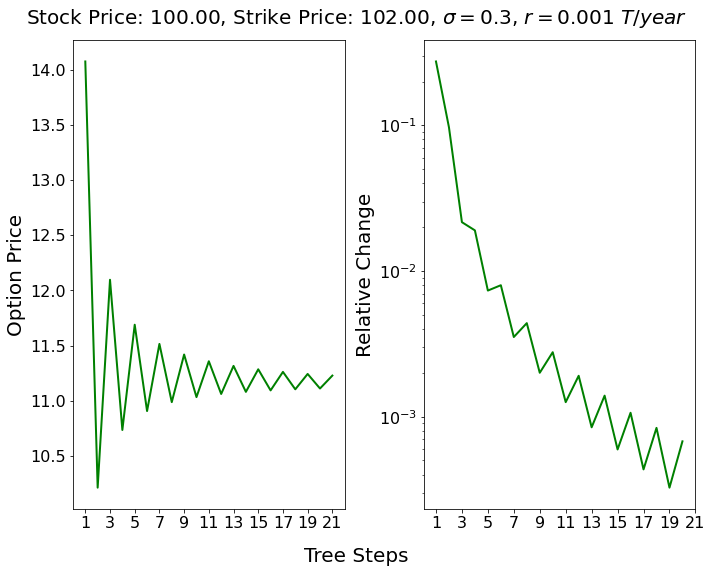

In [128]:
price_convergance = np.array(prices)
rel_change = np.abs(np.gradient(price_convergance))[:-1]/price_convergance[:-1]

fig, axes = plt.subplots(1,2,figsize=(10,8))
axes[0].plot(np.arange(1,price_convergance.size+1),price_convergance,color='g',linewidth=2)
axes[0].set_ylabel('Option Price',size=20)

axes[1].plot(np.arange(1,rel_change.size+1),rel_change,color='g',linewidth=2)
axes[1].set_ylabel('Relative Change',size=20)
axes[1].set_yscale('log')

for ax in axes:
    xlabs = np.arange(1,price_convergance.size+1,int((price_convergance.size+1)/8)) # 8 labels on x axis
    ax.set_xticks(xlabs,fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    
    

fig.supxlabel('Tree Steps',size=20)
fig.suptitle(r'Stock Price: {0:.2f}, Strike Price: {1:.2f}, $\sigma={2}$, $r={3}\ T/year$'.format(price,strike_price,sigma,r_eff),size=20)
fig.tight_layout()

# American Put Example

### Convergence of price at intial time

In [141]:
### Initial tree parameters                                                      ###
### Note: the risk free rate, "r_eff", is units of the entire alloted time "T". ###
### This means that "dt" is always equal to "1/T", but "r_eff" should asorb     ###
### the proper factors to account for this. I.e. if "T" is 2 years and "r" is    ###
### given in per year, it requires theassociated factor of 2 here.               ###
                            ###
    
price = 100
steps = 21
strike_price = price - 2
sigma = 0.3
r_eff = 0.001

root_ami_put = createRoot(price)
prices = []
for t in range(1,steps+1):  
    r = r_eff/t
    u = np.exp(sigma*np.sqrt(1/t))
    d = np.exp(-sigma*np.sqrt(1/t))
    createWithPrices(root_ami_put,t,u,d)
    setFutures(root_ami_put,"American","put",r,strike_price)
    prices.append(root_ami_put.future)
    


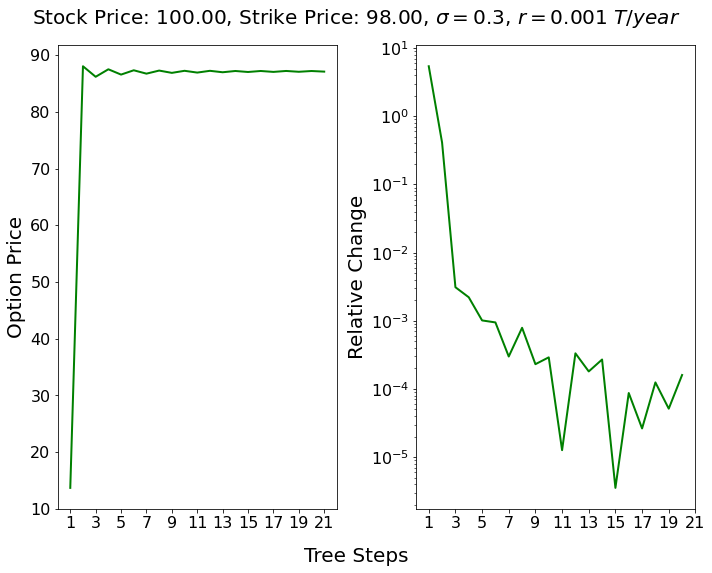

In [142]:
price_convergance = np.array(prices)
rel_change = np.abs(np.gradient(price_convergance))[:-1]/price_convergance[:-1]

fig, axes = plt.subplots(1,2,figsize=(10,8))
axes[0].plot(np.arange(1,price_convergance.size+1),price_convergance,color='g',linewidth=2)
axes[0].set_ylabel('Option Price',size=20)

axes[1].plot(np.arange(1,rel_change.size+1),rel_change,color='g',linewidth=2)
axes[1].set_ylabel('Relative Change',size=20)
axes[1].set_yscale('log')

for ax in axes:
    xlabs = np.arange(1,price_convergance.size+1,int((price_convergance.size+1)/8)) # 8 labels on x axis
    ax.set_xticks(xlabs,fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    
    

fig.supxlabel('Tree Steps',size=20)
fig.suptitle(r'Stock Price: {0:.2f}, Strike Price: {1:.2f}, $\sigma={2}$, $r={3}\ T/year$'.format(price,strike_price,sigma,r_eff),size=20)
fig.tight_layout()

# UNFINISHED EDITS BELOW

# Drawing Tree

In [ ]:
T = 3
G = nx.balanced_tree(2,T)
G=nx.convert_node_labels_to_integers(G, first_label=1, ordering="sorted", label_attribute=None)

nodeNum=len(G.nodes)
while nodeNum > 4:
    if not (math.log(nodeNum+1,2).is_integer()):
        print(nodeNum,nodeNum+1)
        G = nx.contracted_nodes(G,nodeNum,nodeNum+1)
#         del pricingNodeMap[nodeNum+1]
    nodeNum -= 2
       
G.graph["graph"] = dict(rankdir="LR")
pos=graphviz_layout(G, prog='dot')

fig, ax = plt.subplots(figsize=(15,15))

shift=20
pos_nodes_int = {n: (x-shift, y + shift) if n < 2**T else (x + shift/2, y) for n, (x, y) in pos.items()}
pos_nodes = {pricingNodeMap[key]:pos_nodes_int[key] for key in pricingNodeMap}

# nx.relabel_nodes(G, shiftMap, copy=False)

print(G.nodes(),pricingNodeMap, pos)

nx.relabel_nodes(G, pricingNodeMap, copy=False)
pos=graphviz_layout(G, prog='dot')
print("\n",G.nodes(),pricingNodeMap,pos)

nx.draw(G, pos, node_size=2, with_labels=False, arrows=False, ax=ax, node_color="blue")

nx.draw_networkx_labels(G, pos=pos_nodes)

ax.set_title("Test Tree",fontsize=25);

#figure out label text size and positioning, then we are getting a nice tree

In [ ]:
## NEED TO FIX CONTRACTION, E.G. 11, 12, 13 SHOULD _ALL_ BE CONTRACTED, wait actually no


T = 3
G = nx.balanced_tree(2,T)
G=nx.convert_node_labels_to_integers(G, first_label=1, ordering="sorted", label_attribute=None)

# nodeNum=len(G.nodes)
# while nodeNum > 4:
#     if not (math.log(nodeNum+1,2).is_integer()):
#         G = nx.contracted_nodes(G,nodeNum,nodeNum+1)
#         print(nodeNum,nodeNum+1)
# #         del pricingNodeMap[nodeNum+1]
#     nodeNum -= 2

fig, ax = plt.subplots(figsize=(15,15))    

G.graph["graph"] = dict(rankdir="LR")
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, node_size=2, with_labels=False, arrows=False, ax=ax, node_color="blue")
nx.draw_networkx_labels(G, pos=pos);

# nx.relabel_nodes(G, pricingNodeMap, copy=False)
# pos_nodes = {pricingNodeMap[n]: (x-shift, y + shift) 
#                  if n < 2**T else (x + shift/2, y) for n, (x, y) in pos.items()}

# nx.draw_networkx_labels(G, pos=pos_nodes)

# ax.set_title("Test Tree",fontsize=25);


# To-do list:
 ### - connect fully steup trees to networkx diagram drawer
 ### - enable sampled u/d functionality

# Tests

In [ ]:
root = Node(1)
createWithPrices(root,3,1.1,0.9)
prices = ["price{0}\n future{0}\n\n".format(i) for i in range(15)]
newNodeMap = dict(zip(list(getNodes(root)),prices))
newNodeMap

In [ ]:
root = createRoot()
breadthFirstCreate(root,3)
print(list(getNodes(root)))

In [ ]:
root = createRoot([20,None])

In [ ]:
u = 1.1
d = 0.9
T = 2
createWithPrices(root,T,u,d)

In [ ]:
root.left.left.price

In [ ]:
nodes = list(getNodes(root))

In [ ]:
print(nodes)

In [ ]:
getT(root)

In [ ]:
nodes = BFS_DepthList(root);
# [n.key for sub in nodes for n in sub]
for nodette in nodes:
    print([n.price for n in nodette])
print([n.key for n in nodes[-1]])

In [ ]:
setFutures(root,"European","call",0.12*.25,21)
print(list(getNodes(root)))